# The classic pearson correlation 

Pearson correlation in its simplest form measures the linear relationship between two random variables. 

The sample pearson correlation for rnadom variables $(x,y)$ is calculated as:

\begin{align*}
\Large r = \frac{\Sigma(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma(x_i - \bar{x})^2 \Sigma(y_i - \bar{y})^2}}\end{align*}


Under the NHST framework the p-value is calculated under the t-distribution:

\begin{align*}
\large t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^2}}
\end{align*}

$$ \large H_0: r = \rho_0$$
$$ \large H_1: r \neq \rho_0$$

# Bayesian inference

<font size = "3"> Following the quick description of the classic pearson correlation above its important to keep in mind that Bayesian inferences are all derived from the application of Bayes rule $$P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$ and as such while the following description of the Bayesian model is an equivalent to the Pearson correlation, it is fundamentally different, because it uses fully probabilistic modelling and the inferences are not based on sampling distributions</font>
    
<font size = "1"> For a fuller description see the Practicing Bayesian statistics markdown file within the Github repository.</font>

## Bayesian correlation comes in many flavours

The following models, like many Bayesian models, can be parameterized in multiple ways to yield the same inferences. For models used to calculate correlations, a good resource to explore this variation in parameterisation is this [great blog](https://solomonkurz.netlify.app/blog/2019-02-16-bayesian-correlations-let-s-talk-options/) by the fantastic Bayesian/applied stats educator Solomon Kurz. That blog focus on using regressionm modelling framework through use of the Paul Buerkner's R brms package to estimate correlations.

That blog focuses on using a regression modeling framework through Paul Bürkner's R brms package to estimate correlations. This notebook differs though through its focus on a specific form of one of the parameterisations of a model that estimate correlations (specifically multivariate normal models with fixed known 
μ's and σ's) and ignores much of the regression framework nomenclature for a more direct probabilistic modeling perspective/discussion. (Readers, please note that this is more an issue of semantics than substance, as much of the mathematics overlaps, which is why regression-focused software such as brms can estimate correlation models when specified correctly, as demonstrated by Solomon in his blog.)

This parameterisation is chosen because it is the most efficient implementation (however, see the repository for the other model implementations where μ's and σ's are not fixed known values). The code applied here is simpler than the Stan code produced (but concealed) by the brms package used in the blog to achieve the same results for our data analysed here. Hopefully, this will aid individuals in learning Stan code and its direct implementation.

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian data analysis:

1. Identify the relevant data for question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. In the case of scientific research publication is the goal, as such the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predcitve checks to acsetain os the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the posterior

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

In [117]:
# Import data analysis and visualization packages.
import arviz as az
from cmdstanpy import CmdStanModel, write_stan_json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns

#Specify the number of chains to the number of availible cpu's.
n_chains = 4
n_samples = 1000
# Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

In [ ]:
def find_K(n):
    from math import sqrt
    return int((1 + sqrt(1 + 8 * n)) / 2)

def generate_cor_matrix(idata):
    stacked = az.extract(idata)
    means = stacked.rho.mean(axis=1)
    hdis = az.hdi(idata, var_names="rho")

    n = len(means)
    K = find_K(n)

    rhos = np.zeros((K,K))

    # Fill the upper triangle with the means
    idx = 0
    for i in range(K - 1):       # Iterate over rows
        for j in range(i + 1, K):  # Iterate over columns above the diagonal
            rhos[i, j] = means[idx]
            idx += 1

    np.fill_diagonal(rhos, 1.0)

    return(rhos) 


## Step 1 - Identify the relevant data for the question under investigation

The data analysed below if from Dawtry, Sutton, and Sibley (2015) who investigated why people differ in their views on increasing wealth inequality in developed nations. Previous research shows that people generally want a society with high wealth and some level of equality. However, wealthier individuals are more satisfied with the status quo and less supportive of wealth redistribution. The authors suggest that one reason for this is that wealthy people tend to socialize with others in their social circle who are also wealthy, which leads them to overestimate the average wealth in society and perceive the current system as fair.

To test this idea, the authors conducted a study with 305 participants recruited online. Participants reported their own household income, the income of their social circle, and their perception of society's wealth. They also rated their satisfaction with the current system, their views on wealth inequality, their attitudes toward redistribution, and their political preferences.

In [118]:
# Dataset taken from open github repository
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/refs/heads/master/Data/Dawtry%20Sutton%20and%20Sibley%202015.csv"

# Import data into pandas dataframe.
df = pd.read_csv(url)
df.head(3)

,PS,PD_15,PD_30,PD_45,PD_60,PD_75,PD_90,PD_105,PD_120,PD_135,...,redist3,redist4,Household_Income,Political_Preference,age,gender,Population_Inequality_Gini_Index,Population_Mean_Income,Social_Circle_Inequality_Gini_Index,Social_Circle_Mean_Income
0,233,27,48,21,0,0,0,0,0,0,...,6,1,,5,40,2,38.782938,29715,28.056738,21150
1,157,39,0,0,0,0,0,0,0,0,...,3,4,20,5,59,2,37.214511,123630,24.323388,65355
2,275,0,0,50,0,0,50,0,0,0,...,5,5,100,5,41,2,20.750000,60000,14.442577,107100


In [119]:
# Take composite aveage score from the fairness and satisfaction scores.
df["fairness_and_satisfaction"] = df[["fairness", "satisfaction"]].mean(axis=1)

# Reverse code the variables redist2 and redist4
df['redist2_recode'] = 7 - df["redist2"]
df['redist4_recode'] = 7 - df['redist4']

# Calculate the mean from desired redisribution methods.
df['SUPPORT_FOR_REDISTRIBUTION'] = df[['redist1', 'redist2_recode', 'redist3', 'redist4_recode']].mean(axis=1)

In [120]:
variables = [
    "Household_Income",
    'Political_Preference',
    "Population_Mean_Income",
    "Social_Circle_Inequality_Gini_Index",
    "Social_Circle_Mean_Income",
    "Population_Inequality_Gini_Index",
    "SUPPORT_FOR_REDISTRIBUTION",
    "fairness_and_satisfaction"
]

# There empyt cells that are string these can be made to NA values
key_variables = df[variables].apply(pd.to_numeric, errors='coerce')
key_variables = key_variables.dropna()
# Calculate the mean and stnadard devation
means = key_variables.mean()
std_devs = key_variables.std()

In [121]:
print("Print key variables means")
print(means, "\n")
print("Print key variables standard deviation")
print(std_devs)

Print key variables means
Household_Income                       55003.983131
Political_Preference                       4.464646
Population_Mean_Income                 58976.818182
Social_Circle_Inequality_Gini_Index       26.324010
Social_Circle_Mean_Income              54168.838384
Population_Inequality_Gini_Index          35.417705
SUPPORT_FOR_REDISTRIBUTION                 3.904040
fairness_and_satisfaction                  3.537037
dtype: float64 

Print key variables standard deviation
Household_Income                       47395.979772
Political_Preference                       2.245024
Population_Mean_Income                 17144.209735
Social_Circle_Inequality_Gini_Index        9.977284
Social_Circle_Mean_Income              25189.199190
Population_Inequality_Gini_Index           7.470944
SUPPORT_FOR_REDISTRIBUTION                 1.156854
fairness_and_satisfaction                  2.026924
dtype: float64


,Variable 1,Variable 2,Correlation,lower hdi,upper_hdi
0,Household_Income,Political_Preference,0.140752,0.033754,0.242170
1,Household_Income,Population_Mean_Income,0.172306,0.070964,0.274622
2,Household_Income,Social_Circle_Inequality_Gini_Index,-0.112008,-0.215589,-0.007036
3,Household_Income,Social_Circle_Mean_Income,0.470531,0.391818,0.548056
4,Household_Income,Population_Inequality_Gini_Index,-0.055531,-0.156227,0.047309
5,Household_Income,SUPPORT_FOR_REDISTRIBUTION,-0.195171,-0.295351,-0.093877
6,Household_Income,fairness_and_satisfaction,0.168076,0.066732,0.268594
7,Political_Preference,Population_Mean_Income,-0.014050,-0.120018,0.090128
8,Political_Preference,Social_Circle_Inequality_Gini_Index,-0.045404,-0.155147,0.055259
9,Political_Preference,Social_Circle_Mean_Income,0.136680,0.031009,0.244079


# Step 2 - Define the descriptive statistical model

$$
\begin{align*}
y_{ij} &\sim \text{MultivariateNormal}(\mu_k, \Sigma) \\
\mu_k &= [0,0] \\
\sigma_k &= [1,1] \\
\rho &\sim \text{LKJ}(1) \\
\Sigma &\sim MVN\bigg(\mu_k, 
\begin{bmatrix}
\sigma_1^2 & \rho \sigma_1 \sigma_2 \\
\rho \sigma_1 \sigma_2 & \sigma_2^2 
\end{bmatrix}\bigg)
\end{align*}
$$


As stated above the model above allows for the estimation of correlation between variables similarly to classic Pearson correlation. The biggest difference here though is because we are only interested in the correlations we can standardise the data and then assume that the $\mu's$ & $\sigma's$ are known in the model (as 0 and 1 repectively) as they are not of interest in this case whilst still preserving the same covariance in the data to estimate correlation between the variables of interest. This method becomes more valuable as the number of correlations you wish to estimate increases as it greatly reduces the number of parameters that are needed to be estimated and allows for more stable computation.

# Step 4 - use Bayes rule

# Stan model for multiple correlation estimation

In [122]:
# Generate Python dicitonary to pass to Stan data block with relevant variables.
data = {
        'N': len(key_variables),
        'K': key_variables.shape[1],
        'y': key_variables.apply(lambda x: (x - x.mean()) / x.std(), axis=0),
        'mu': np.repeat(0, key_variables.shape[1]),
        'sigma': np.repeat(1, key_variables.shape[1])
       }

In [151]:
model_path = "stan/correlation_fixed.stan"
sm = CmdStanModel(stan_file = model_path, cpp_options={'STAN_THREADS': 'TRUE'},
                     force_compile = True)   

13:48:54 - cmdstanpy - INFO - compiling stan file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/wip2/Chapter_3_-_Correlation/stan/correlation_fixed.stan to exe file /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/wip2/Chapter_3_-_Correlation/stan/correlation_fixed
13:49:16 - cmdstanpy - INFO - compiled model executable: /home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/wip2/Chapter_3_-_Correlation/stan/correlation_fixed
13:49:16 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
13:49:16 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=correlation_fixed.stan --o=/home/harrison/Desktop/githubrepos/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/wip2/Chapter_3_-_Correlation/stan/co

In [153]:
write_stan_json("data.json", data = data)

# Fit the One_z_test_model specified above.
fit = sm.sample("data.json", chains = n_chains , iter_sampling=n_samples, iter_warmup = n_warmup, parallel_chains = n_chains, adapt_delta = stepS)

13:49:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:49:30 - cmdstanpy - INFO - CmdStan done processing.
13:49:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'correlation_fixed.stan', line 24, column 4 to column 29)
	Exception

In [238]:
# Convert to xarray object.
idata = az.from_cmdstanpy(
    posterior = fit,
    posterior_predictive = ['yrep'],
    observed_data={'y': data['y']}  
)
stacked = az.extract(idata)

## Step 5 - Posterior predictive checks

For this correlation model some of these checks make less sense, because implicitly many of the parameters are assumed to be known as 0 or 1, and we are only interested to how much the variables are correlated. However, posterior checks to see if posterior samples have no pathological issues is still crucial.

## Posterior

In [239]:
az.summary(idata, var_names="rho")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],0.141,0.055,0.034,0.242,0.001,0.001,3700.0,3078.0,1.0
rho[1],0.172,0.054,0.071,0.275,0.001,0.001,4501.0,2762.0,1.0
rho[2],-0.112,0.055,-0.216,-0.007,0.001,0.001,5022.0,3234.0,1.0
rho[3],0.471,0.042,0.392,0.548,0.001,0.000,4896.0,2349.0,1.0
rho[4],-0.056,0.056,-0.156,0.047,0.001,0.001,5024.0,3261.0,1.0
rho[5],-0.195,0.054,-0.295,-0.094,0.001,0.001,2914.0,2997.0,1.0
rho[6],0.168,0.053,0.067,0.269,0.001,0.001,3130.0,3084.0,1.0
rho[7],-0.014,0.055,-0.120,0.090,0.001,0.001,4415.0,3432.0,1.0
rho[8],-0.045,0.057,-0.155,0.055,0.001,0.001,5304.0,3132.0,1.0
rho[9],0.137,0.056,0.031,0.244,0.001,0.001,4735.0,2847.0,1.0


In [ ]:
# Let amke those paramter values more understandable
# Generate list of pairs fro upper triangle of cooreltion coefficents.
pairs = [(variables[i], variables[j]) for i in range(len(variables)) for j in range(i+1, len(variables))]
means = stacked.rho.mean(axis=1)
hdis = az.hdi(idata, var_names="rho")

correlation_df = pd.DataFrame({
    "Variable 1": [p[0] for p in pairs],
    "Variable 2": [p[1] for p in pairs],
    "Correlation coefficent": means,
    "lower_hdi": hdis.rho[:,0],
    "upper_hdi": hdis.rho[:,1]
})

# Generate data frame for correltions
correlation_df


,Variable 1,Variable 2,Correlation,lower hdi,upper_hdi
0,Household_Income,Political_Preference,0.140752,0.033754,0.242170
1,Household_Income,Population_Mean_Income,0.172306,0.070964,0.274622
2,Household_Income,Social_Circle_Inequality_Gini_Index,-0.112008,-0.215589,-0.007036
3,Household_Income,Social_Circle_Mean_Income,0.470531,0.391818,0.548056
4,Household_Income,Population_Inequality_Gini_Index,-0.055531,-0.156227,0.047309
5,Household_Income,SUPPORT_FOR_REDISTRIBUTION,-0.195171,-0.295351,-0.093877
6,Household_Income,fairness_and_satisfaction,0.168076,0.066732,0.268594
7,Political_Preference,Population_Mean_Income,-0.014050,-0.120018,0.090128
8,Political_Preference,Social_Circle_Inequality_Gini_Index,-0.045404,-0.155147,0.055259
9,Political_Preference,Social_Circle_Mean_Income,0.136680,0.031009,0.244079


## Traceplot

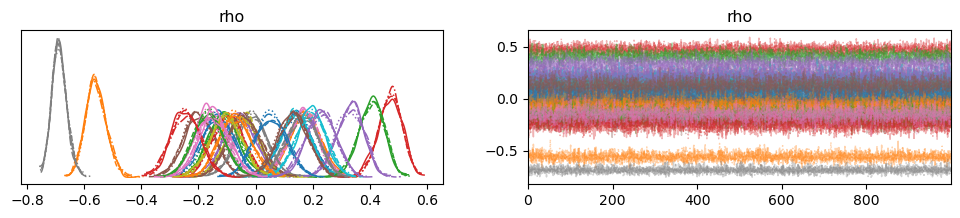

In [183]:
az.plot_trace(idata, var_names="rho");

Traceplot shows no pathlogical issue with good chain mixing 'Fuzzy caterpillars'

# Reporting the results of the Bayesian correlation

<font size = "3">As Kruschke (2015) correctly points out there is no standard formula for presentation of results of Bayesian data analysis in journal articles like the APA guide for reporting frequentist analysis. It is likely there never will be, because as McElreath (2020) explains, Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) argue visualisations maybe even more key for describing an analysis (show dont tell). As such, all the visualisations used above would likely be included with any write up. Anyhow, the write up below generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>

# References

Bürkner, P. C. (2017). brms: An R package for Bayesian multilevel models using Stan. Journal of statistical software, 80(1), 1-28.

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.

Vehtari, A., Gelman, A., Simpson, D., Carpenter, B., & Bürkner, P. C. (2019). Rank-normalization, folding, and localization: An improved $\widehat {R} $ for assessing convergence of MCMC. arXiv preprint arXiv:1903.08008.